# Neural Network Model: Predicting the Most Common Kind of Tree Cover

In this project, a neural network model will be created in order to predict the forest cover type of a certain area based on geographic and cartographic variables. The variables included in the dataset were derived from data obtained from the US Geological Survey and US Forest Service (USFS). The actual forest cover type for a given 30 x 30 meter cell was determined from the USFS Region 2 Resource Information System Data. 

Four areas were included in the study, located in the Roosevelt National Forest of northern Colorado. These areas were selected due to their minimal human-caused disturbances. In this way, existing forest cover types are likely a result of ecological processes rather than forest management pratices. 

The covertypes fall within this 7 categories:
* Spruce/Fir
* Lodgepole Pine
* Ponderosa Pine
* Cottonwood/Willow
* Aspen
* Douglas-fir
* Krummholz

## Objectives

* Explore and preprocess the data. Anayse the type of variables included in the dataset, and whether they contain missing values or outliers. Determine whether feature scaling and handling of categorical data is necessary.
* Split data into train, validation, and test dataset. Check for class imbalance in the response variable.
* Build and implement the model. Chose the model architecture. Optimize the architecture and hyperparameters.
* Evaluate the model performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import zscore

from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv('cover_data.csv')
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

A first glance into the data tells us that the dataset contains 581012 observations and 53 features (+ the outcome variable `class`). There does not seem to be missing or null values in the dataset. As the `soil_type`, `Wilderness_area` and `class` categorical variables have already been encoded into numerical values, there is no need for handling categorical data. 

As for the quantitative features, they need to be scaled to avoid model bias. 

In [5]:
data.describe(include='all')

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [6]:
# Separate data into features and label
features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

# Select the quantitative features for future scaling
quant_features = data.iloc[:, :10]
list(quant_features.columns)

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points']

In [7]:
labels.value_counts()

class
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

C:\Users\CristinaFC\AppData\Local\Temp\ipykernel_23788\1095445195.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts_named.values, y=class_counts_named.index, palette='viridis')


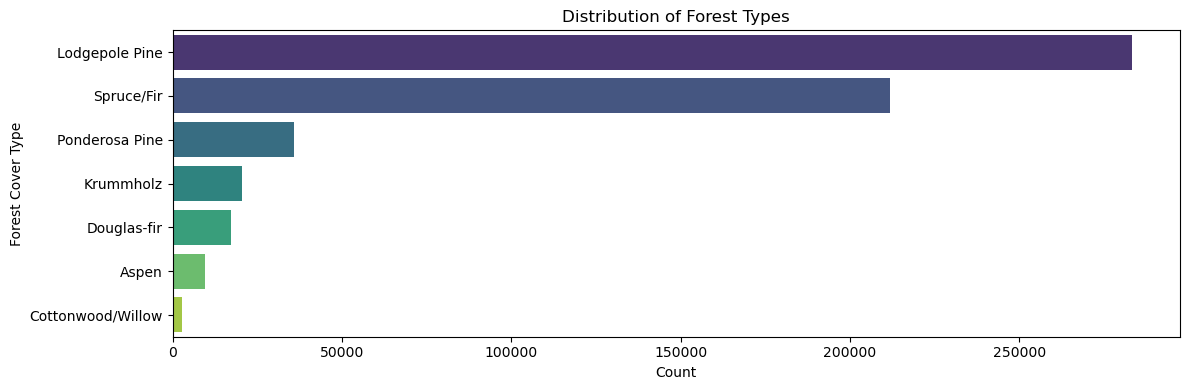

In [8]:
class_counts = labels.value_counts()
class_names = {1: 'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas-fir', 7:'Krummholz'}

# Map numeric codes to names
class_counts_named = class_counts.rename(index=class_names)

# Create a bar plot with the tree classes distribution in the dataset
plt.figure(figsize=(12, 4))
sns.barplot(x=class_counts_named.values, y=class_counts_named.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Forest Cover Type')
plt.title('Distribution of Forest Types')
plt.tight_layout()
plt.show()

The labels of the dataset are heavily unbalanced, with most of the observations being labeled as `Spruce/Fir` or `Logepole Pine` (\~500.000) and the remaining observations (~80.000) labeled as one of the other 5 categories. This may compromise the model's performance, as it may be biased towards the dominating categories. In order to mitigate class imbalance, the training and validation sets will be splitted using stratified. This will guarantee that both sets have the same proportion of examples from each class.

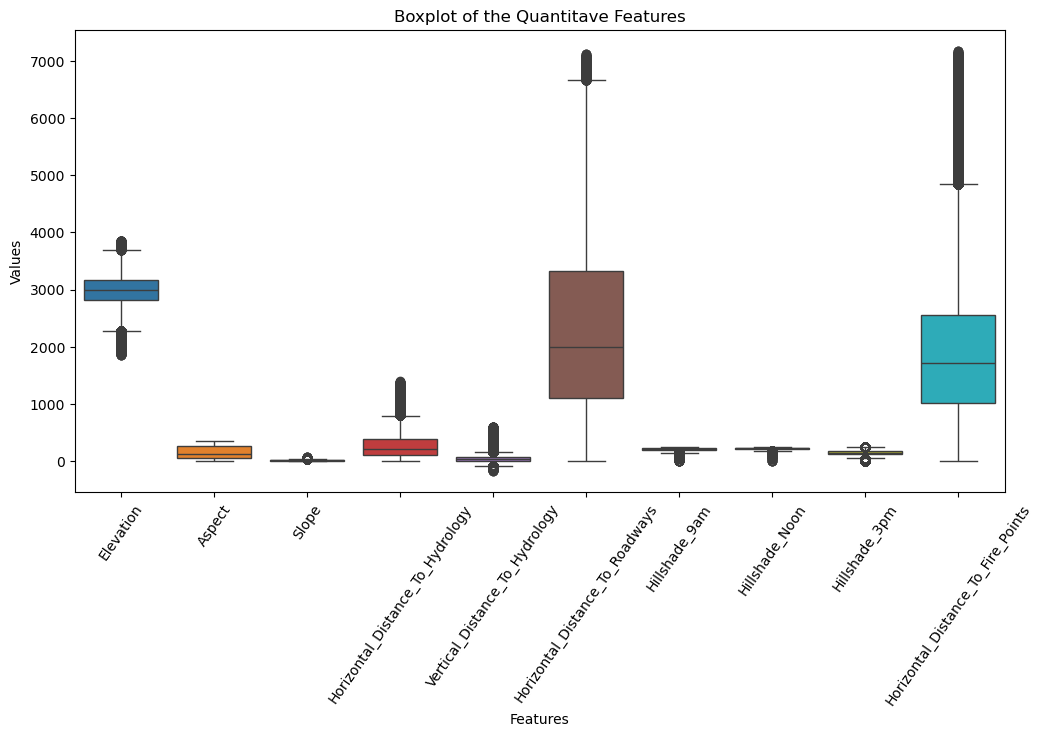

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=quant_features)
plt.title("Boxplot of the Quantitave Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=55)
plt.show()

As features have different ranges, in the next couple of cells they are divided into two different boxplots in order to apreciate better their distribution.

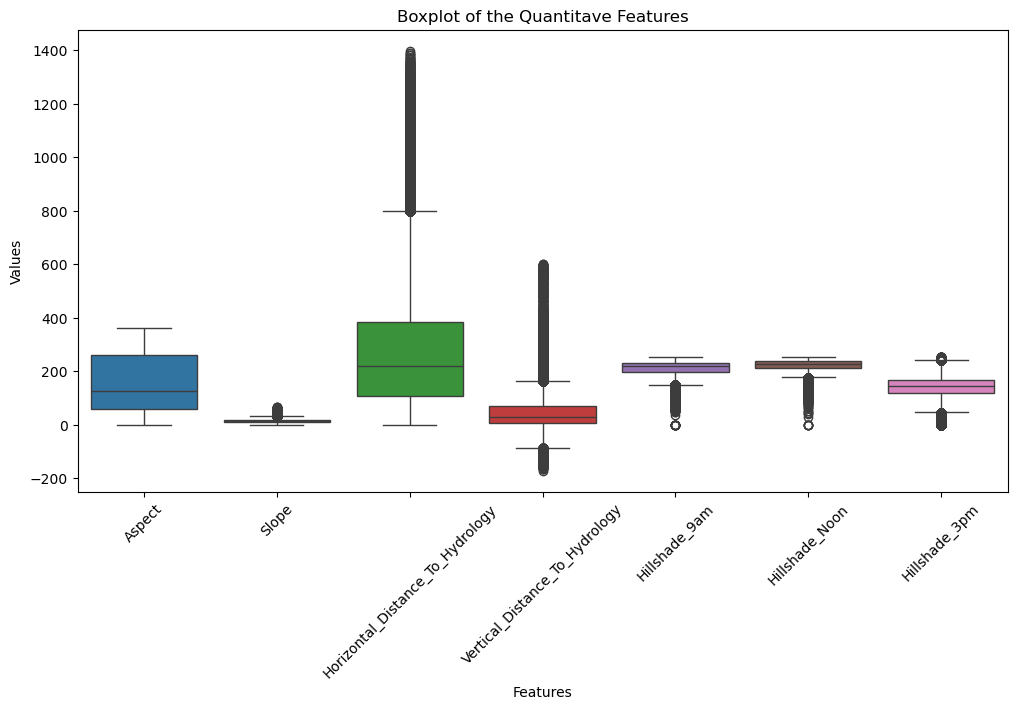

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=features[['Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']])
plt.title("Boxplot of the Quantitave Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

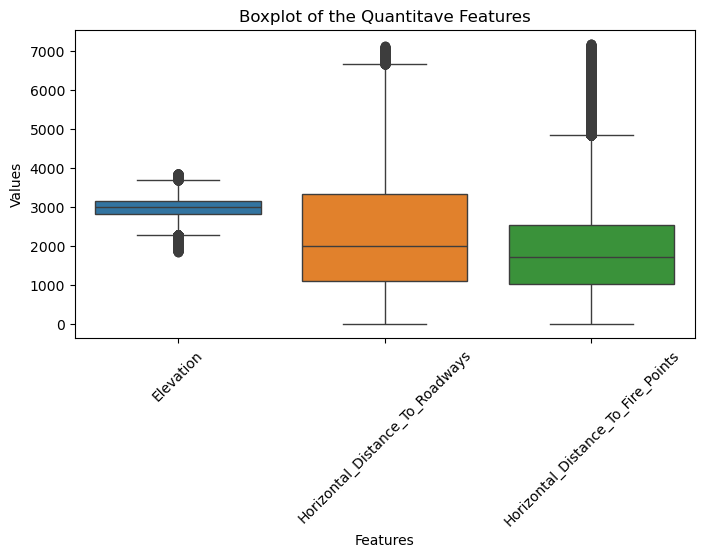

In [21]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=features[['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']])
plt.title("Boxplot of the Quantitave Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()


As shown by the boxplots, some of the quantitative features of the dataset are skeewed and/or contain observations away from the central trend. It should be noted that some features, `like Horizontal_Distance_To_Hydrology`, exhibit extreme ranges with numerous outliers. Others, such as `Slope` or `Hillshade_9am`, have tighter distributions with fewer outliers.In the next steps, the features and labels will be split into training and validation set. The training set will be corrected for potential outliers using the Z-score (considering outliers the observations with z-scores outside of the threshold between -4 and 4). Then the data will be scaled using normalization using the training set to fit the scaler and appling the scaler transformation to both the training and validation sets.

In [25]:
# Split data into training and validation_test sets
x_train, x_val_test, labels_train, labels_val_test = train_test_split(features, labels, random_state=13, test_size=0.3, stratify=labels)
# Split the validation_test set into validation set and test set
x_val, x_test, labels_val, labels_test = train_test_split(x_val_test, labels_val_test, random_state=13, test_size=0.5, stratify=labels_val_test)

print(x_train.shape)
print(labels_train.shape)
print(x_test.shape)
print(x_test.shape)

(406708, 54)
(406708,)
(87152, 54)
(87152, 54)


In [27]:
# Compute the z-scores for each feature
z_scores = zscore(x_train)

# Identify outliers (absolut z_score > threshold)
threshold = 4
mask = (abs(z_scores) < threshold).all(axis=1)
# Filter out the outliers using the mask
x_train_clean, labels_train_clean = x_train[mask], labels_train[mask]

In [29]:
print(x_train_clean.shape)
print(labels_train_clean.shape)

(177385, 54)
(177385,)


Handling the outliers by using the z-score results in the removal of almost half of the observations. Therefore causing a substantial loss in information. Given that some features like `Horizontal_Distance_To_Hydrology` may naturally have a wider spread - meaning extreme values may not truly be 'outliers' - the outliers will be handle using feature-specific thresholds instead of a global threshold (e.g. Z-score of 4). The feature specific thresholds will be informed by the percentiles. 

Instead of removing outliers, they will be capped to a reasonable range (based on the 1st and 99th percentile). This retains the data while limiting the influence of extreme values.

In [32]:
# Set lower cap to the 5th percentile
lower_cap = x_train.quantile(0.01)
# Set the upper cap to the 95th percentile
upper_cap = x_train.quantile(0.99)
# Cap outliers
x_train_cap = x_train.clip(lower=lower_cap, upper=upper_cap, axis=1)


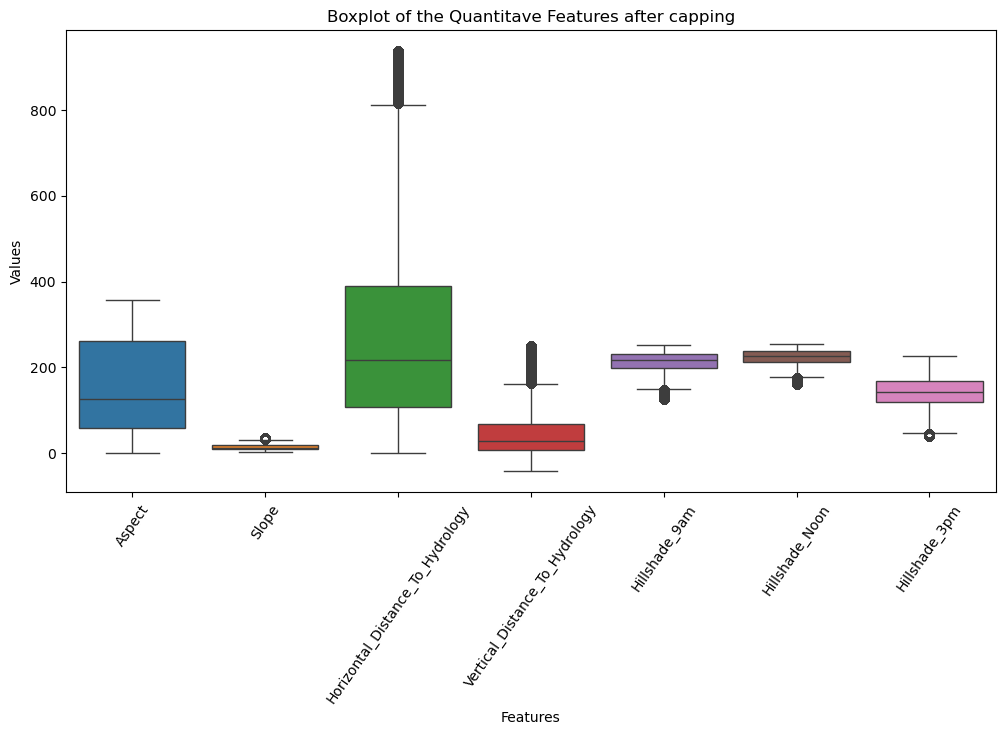

In [34]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=x_train_cap[['Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']])
plt.title("Boxplot of the Quantitave Features after capping")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=55)
plt.show()

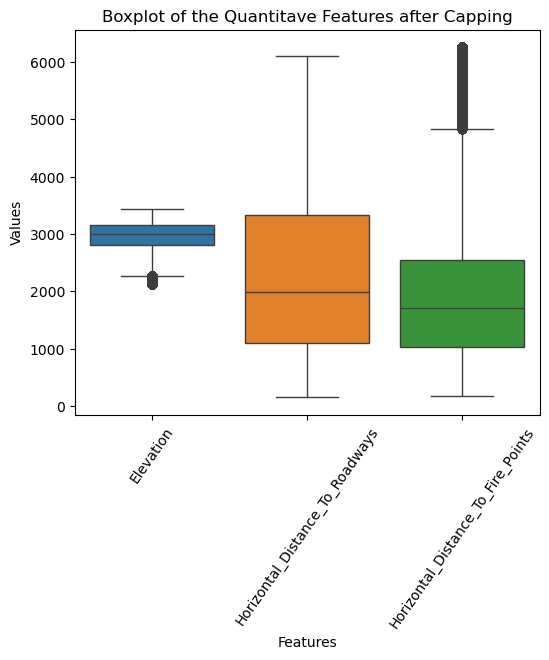

In [35]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=x_train_cap[['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']])
plt.title("Boxplot of the Quantitave Features after Capping")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=55)
plt.show()

Using this strategy, the distribution of the features is smoother with less values outside the central distribution. As I have used the 1st and 99th percentiles, only 2% of the original information has been loss, which is less likely to cause model bias. 

Since the outliers have been handled, the features will be standardize using normalization.

In [39]:
# Initialize transform object
ct = ColumnTransformer([('normalize', Normalizer(), list(quant_features.columns))], remainder='passthrough')
# Fit the transformer with the x_train_cap data and scale it
x_train_norm = ct.fit_transform(x_train_cap)
# Scale the x_val data
x_val_norm = ct.transform(x_val)
# Scale the x_test data
x_test_norm = ct.transform(x_test)
                           
# Convert back to dataframe 
features_train_norm = pd.DataFrame(x_train_norm, columns=features.columns)
features_train_norm.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.506282,0.024093,0.003670,0.045155,0.013084,0.819337,0.038454,0.037177,0.017232,0.257688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.525273,0.029568,0.003028,0.049339,0.013181,0.795836,0.041324,0.043461,0.024224,0.288197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.746523,0.012932,0.003527,0.134021,0.027039,0.364444,0.053609,0.048671,0.025394,0.533970,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.817848,0.040763,0.002596,0.152925,0.029339,0.497719,0.060235,0.062831,0.036349,0.220429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.782519,0.109376,0.012846,0.024591,0.014314,0.499535,0.046613,0.071205,0.082950,0.333268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


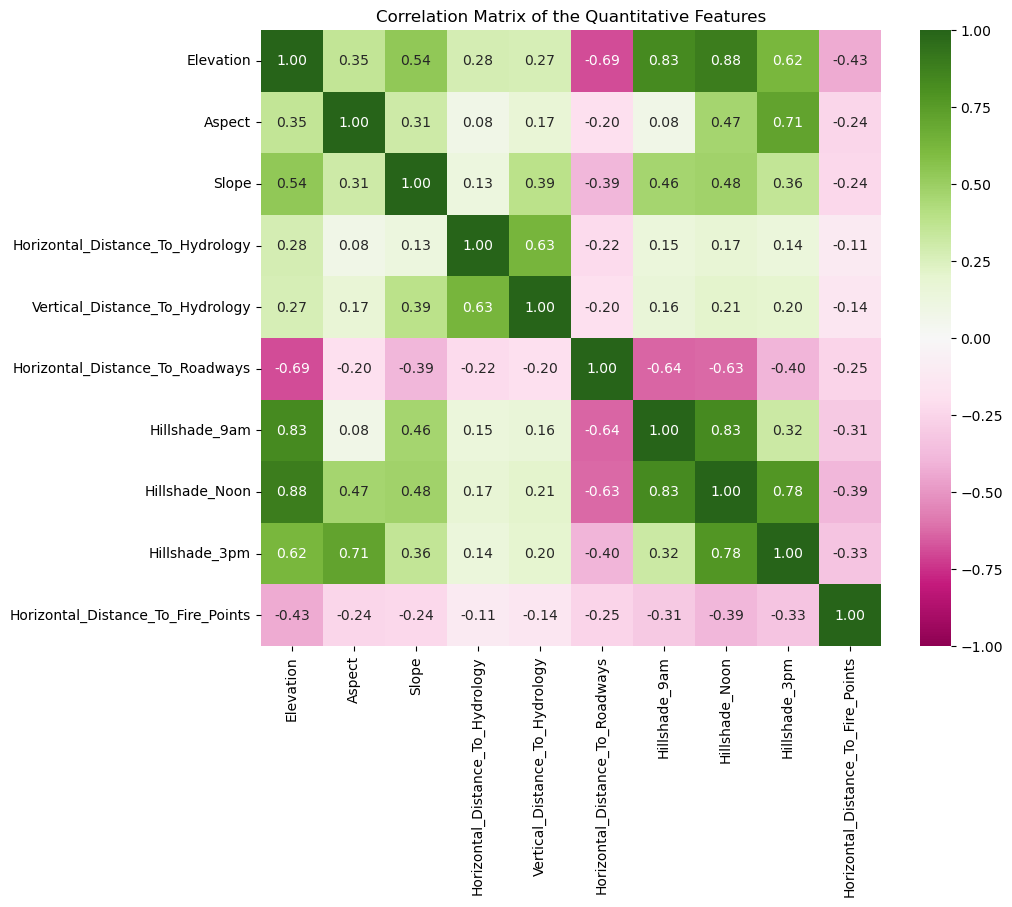

In [41]:
# Correlation matrix of quantitative features
correlation_matrix = features_train_norm[quant_features.columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='PiYG', vmin=-1, vmax=1)
plt.title('Correlation Matrix of the Quantitative Features')
plt.show()


The correlation matrix shows some interesting relationships between features. For example, `Elevation` seems to have a strong positive correlation with the amount of hillshade at different times of the day. The variable `Horrizontal_Distance_To_Roadways` shows a negative correlation with both `Elevation` and hillshade at different times of the day. The hillshade at either 9am, noon, or 3pm are positively correlated between them (especially `Hillshade_Noon` with respect to the other two time points) and show weaker positive correlations with other characteristics of the terrain  including `Aspect` or `Slope` and weak negative correlation towards `Horizontal_Distance_To_Firepoints`. The variables related to the the distance to hydrology (both vertical and horizontal) only show a weak positive correlation with `Elevation`.

## Neural Network Model

In [45]:
# Convert the labels to one hot 
labels_train_enc = tf.keras.utils.to_categorical(labels_train -1, num_classes=7) # -1 is added as labels need to be 0-indexed instead of 1-indexed
labels_val_enc = tf.keras.utils.to_categorical(labels_val -1, num_classes=7) # -1 is added as labels need to be 0-indexed instead of 1-indexed
labels_test_enc = tf.keras.utils.to_categorical(labels_test -1, num_classes=7) # -1 is added as labels need to be 0-indexed instead of 1-indexed
labels_train_enc

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [47]:
def build_model(features, learning_rate):
    
    model = Sequential()
    # Input layer
    model.add(layers.InputLayer(input_shape=(features.shape[1],)))
    # First hidden layer
    model.add(layers.Dense(64, activation='relu'))
    # Add dropout layer
    # model.add(layers.Dropout(0.1))
    # Second hidden layer
    model.add(layers.Dense(32, activation='relu'))
    # Third hidden layer
    model.add(layers.Dense(8, activation='relu'))
   
    # Output layer
    num_classes = 7
    model.add(layers.Dense(num_classes, activation='softmax'))
     # Add optimizer
    opt = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [49]:
def plot_history(history, params):
    for param in params:
        if param == 'acc':
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.title('Model Accuracy')
            plt.legend(['train','val'])
            plt.show()
        elif param == 'loss':
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Model Loss')
            plt.legend(['train','val'])
            plt.show()
    

In [122]:
# Initialise the model 
model = build_model(x_train_norm, 0.001)
print(model.summary())
# Fit tne model with the training data 
#model.fit(x_train_norm, labels_train, epochs=30, batch_size=3, verbose=1)

C:\Users\CristinaFC\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,927 (23.15 KB)

 Trainable params: 5,927 (23.15 KB)

 Non-trainable params: 0 (0.00 B)

None


In [124]:
# Instantiate a EarlyStopping object
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
# Select hyperparameter values
num_epochs = 50
batch_size = 256

# Fit tne model with the training data 
history = model.fit(x_train_norm, 
                    labels_train_enc, 
                    epochs=num_epochs, 
                    batch_size=3,
                    callbacks=[es],
                    validation_data=(x_val_norm, labels_val_enc), 
                    verbose=1)

Epoch 1/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 477s 3ms/step - accuracy: 0.6549 - loss: 0.7626 - val_accuracy: 0.7332 - val_loss: 0.6181
Epoch 2/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 462s 3ms/step - accuracy: 0.7365 - loss: 0.5980 - val_accuracy: 0.7488 - val_loss: 0.5756
Epoch 3/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 200s 1ms/step - accuracy: 0.7597 - loss: 0.5502 - val_accuracy: 0.7690 - val_loss: 0.5357
Epoch 4/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 211s 2ms/step - accuracy: 0.7740 - loss: 0.5234 - val_accuracy: 0.7816 - val_loss: 0.5198
Epoch 5/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 205s 2ms/step - accuracy: 0.7820 - loss: 0.5062 - val_accuracy: 0.7836 - val_loss: 0.5111
Epoch 6/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 208s 2ms/step - accuracy: 0.7887 - loss: 0.4936 - val_accuracy: 0.7879 - val_loss: 0.4988
Epoch 7/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 209s 2ms/step - accuracy: 0.7925 - loss: 0.4840 - val_accuracy: 0.7937 - val_loss: 0.4887
Epoch 8/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 21

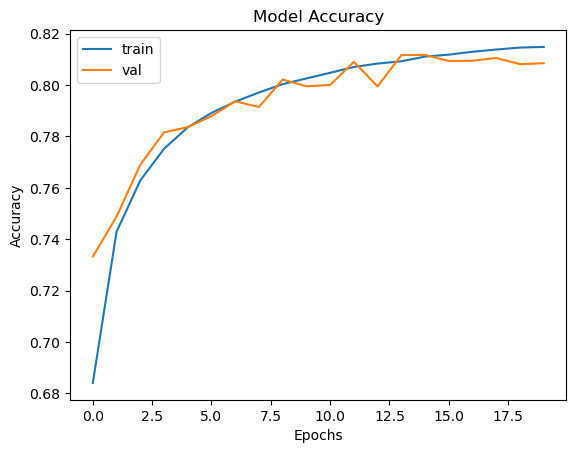

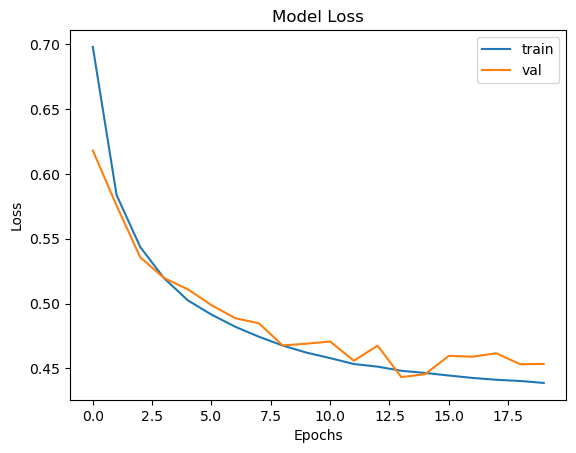

In [128]:
plot_history(history, ['acc', 'loss'])

The training accuracy steadily increases over epochs, as well as the training loss gradually decreases over epochs. This suggests that the model is effectively learning the patterns of the training data. In both cases, the curve for the validation data goes in parallel witht he training curve, which indicates that the model is not overfitting sifnificantly and is therefore able to generalize to unseen data. There seems to be minor fluctuations in the validation loss after about 10 epochs, which is normal and could be attributed to noise or small variations in the validation set. 

Various model architectures were tested in order to optimize the model performance. The addition of regularization through a dropout layer was atempted but lead to instable learning. The batch size and learning rate were also tuned to achive better model predictive power. 

In [130]:
loss, acc = model.evaluate(x_test_norm, labels_test_enc, verbose=0)
print(f'Model Accuracy Score: {acc}')
print(f'Model loss: {loss}')

Model Accuracy Score: 0.8053974509239197
Model loss: 0.45633140206336975


Although the model accuracy and loss scores indicate good generalization, these metrics do not reflect the performance on underrepresented classes due to class imbalance. Therefore, the model performance on individual classes is evaluated below using a classification report and a confusion matrix to ensure the model is not neglecting minority classes. 

In [51]:
def class_report(pred_prob, true_prob):
    # Convert prediction probabilites into class indices
    pred_class = np.argmax(pred_prob, axis=1)
    # Convert true probabilities into class indices
    true_class = np.argmax(true_prob, axis=1)
    class_names_list = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
    class_report= classification_report(true_class, pred_class, target_names=class_names_list, labels=range(7))
    print(class_report)

In [53]:
def plot_cm(pred_prob, true_prob):
    # Convert prediction probabilites into class indices
    pred_class = np.argmax(pred_prob, axis=1)
    # Convert true probabilities into class indices
    true_class = np.argmax(true_prob, axis=1)
    class_names_list = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

    cm = confusion_matrix(true_class, pred_class)
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list, yticklabels=class_names_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

In [136]:
# Predict the labels from the test set
labels_test_prob = model.predict(x_test_norm)

# Generate a classification report
class_report(labels_test_prob, labels_test_enc)


2724/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 679us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.80      0.80      0.80     31776
   Lodgepole Pine       0.83      0.84      0.83     42496
   Ponderosa Pine       0.78      0.81      0.80      5363
Cottonwood/Willow       0.56      0.71      0.63       412
            Aspen       0.52      0.55      0.53      1424
      Douglas-fir       0.69      0.56      0.62      2605
        Krummholz       0.90      0.67      0.77      3076

         accuracy                           0.81     87152
        macro avg       0.73      0.71      0.71     87152
     weighted avg       0.81      0.81      0.80     87152



The model performs well on the dominant classes (`Spruce/Fir` and `Lodgepole Pine`) but performance drop significantly for the less represented clases (`Cottonwood/Willow`, `Aspen`, and `Douglas-Fir`). The classes `Ponderosa Pine` and `Krummholz` also showed good performance despite their relatively low amount instances in the dataset. 

This result indicates that the model struggles to identify the minority classes correctly and avoid missclassification. 

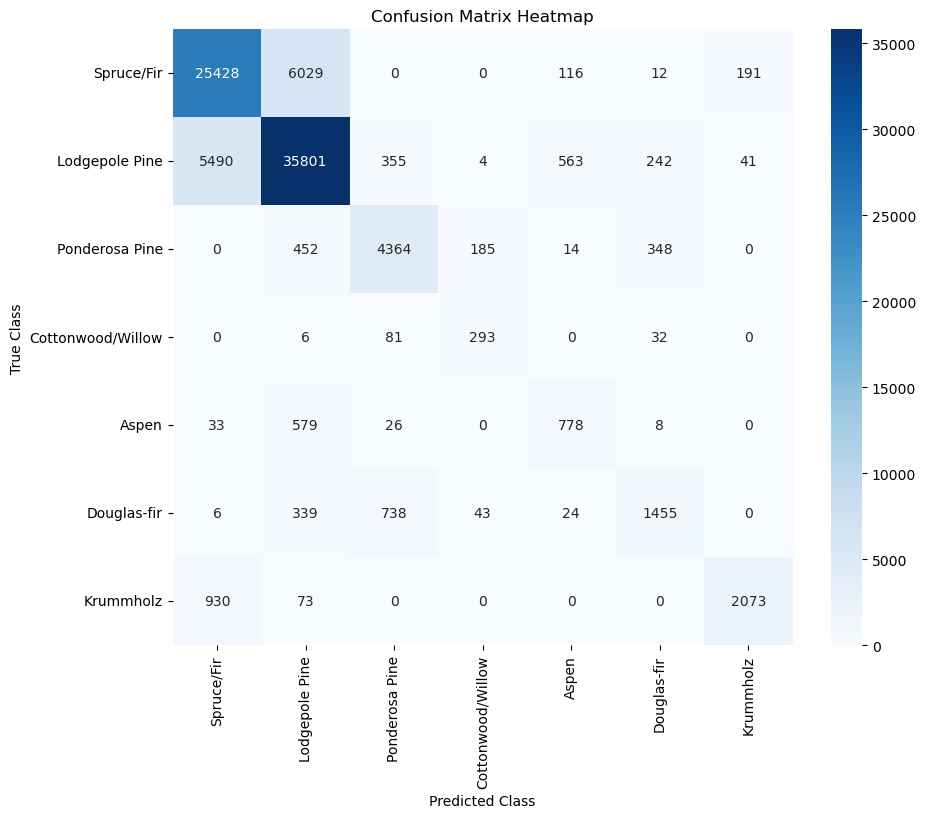

In [138]:
# Create a confusion matrix heatmap
plot_cm(labels_test_prob, labels_test_enc)


The confusion matrix ilustrates the observations from the classification report. The model seem to be biased towards the majority classes and struggles to classify properly the classes with lower representation on the dataset. For example, 570 areas with `Aspen` as covertype has been misclassified as `Logepole Pine`, in contrast with the 778 correctly classified `Aspen` areas. 

In order to reduce the bias towards the majority classes and improve the predictive capacity of the model, another model will be built using class weights during training. This will assign higher weights to minority classes. 

In [55]:
# Calculate the weights of each class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(labels_train_enc, axis=1)),
    y=np.argmax(labels_train_enc, axis=1)
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.3918128429619582,
 1: 0.29298140717635446,
 2: 2.3214456951071942,
 3: 30.2138028378278,
 4: 8.743588089863485,
 5: 4.779233598514671,
 6: 4.0468860386670515}

In [55]:
weight_model = build_model(x_train_norm, 0.001)

# Instantiate a EarlyStopping object
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
# Select hyperparameter values
num_epochs = 50
batch_size = 1024

weight_history = weight_model.fit(
    x_train_norm,
    labels_train_enc,
    epochs=num_epochs, 
    batch_size=3,
    callbacks=[es],
    validation_data=(x_val_norm, labels_val_enc), 
    class_weight=class_weight_dict,
    verbose=1)

C:\Users\CristinaFC\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 268s 2ms/step - accuracy: 0.4990 - loss: 0.9955 - val_accuracy: 0.5220 - val_loss: 1.0323
Epoch 2/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 242s 2ms/step - accuracy: 0.5354 - loss: 0.7916 - val_accuracy: 0.5429 - val_loss: 1.0070
Epoch 3/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 248s 2ms/step - accuracy: 0.5658 - loss: 0.7345 - val_accuracy: 0.5992 - val_loss: 0.9301
Epoch 4/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 216s 2ms/step - accuracy: 0.5975 - loss: 0.6912 - val_accuracy: 0.6024 - val_loss: 0.9136
Epoch 5/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 208s 2ms/step - accuracy: 0.6098 - loss: 0.6702 - val_accuracy: 0.5928 - val_loss: 0.9207
Epoch 6/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 215s 2ms/step - accuracy: 0.6179 - loss: 0.6468 - val_accuracy: 0.6414 - val_loss: 0.8320
Epoch 7/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 220s 2ms/step - accuracy: 0.6284 - loss: 0.6371 - val_accuracy: 0.6279 - val_loss: 0.8631
Epoch 8/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 21

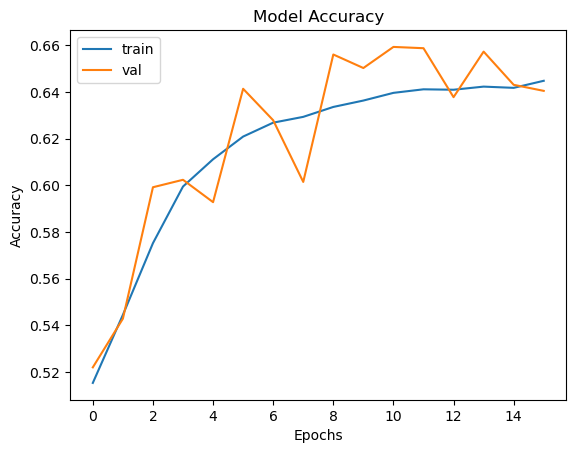

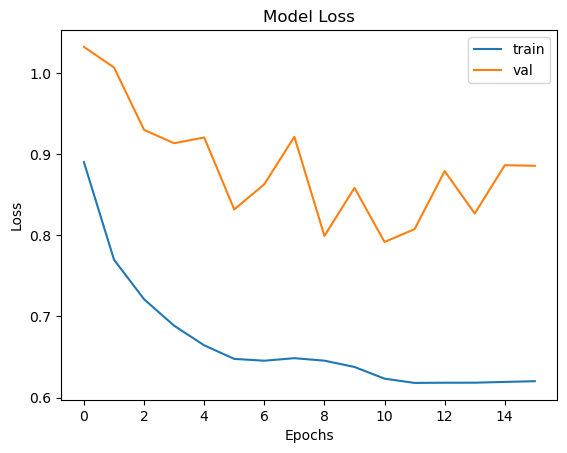

In [72]:
plot_history(weight_history, ['acc', 'loss'])

In [90]:
loss, acc = weight_model.evaluate(x_test_norm, labels_test_enc, verbose=0)
print(f'Model Accuracy Score: {acc}')
print(f'Model loss: {loss}')

Model Accuracy Score: 0.6416605710983276
Model loss: 0.8802638649940491


Both the training and validation accuracy increase steadily over time, which is a good sign. Validation accuracy fluctuates considerably compare to the training accuracy. This could be due to the variability introduced by the class weights. As the training and validation accuracy remain relatively close throughout the epochs, the model does not seem to overfit.

Regarding the loss, the training loss decreases steadily over epochs, indicating that the model is learning well from the training data. The falidation loss fluctuates and does not decrease smoothly. The fluctuations could be caused by the class imbalance and the use of class weights. The fact that validation loss is higher than the training loss is typical when using class weights, as the model gives more importance to underrepresented classes. In fact, the model was run also in the presence of dropout regularization to reduce the gap between validation loss and training loss, but the model did not improve. 

In short, it seems that class weights are helping to mitigate class imbalance, but at the same time they may be causing instability during validation, as underrepresented classes have a disproportionately larger effect on the loss function. 

In [84]:
labels_pred = weight_model.predict(x_test_norm)

class_report(labels_pred, labels_test_enc)

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.76      0.58      0.66     31776
   Lodgepole Pine       0.74      0.65      0.70     42496
   Ponderosa Pine       0.70      0.63      0.66      5363
Cottonwood/Willow       0.44      0.81      0.57       412
            Aspen       0.19      0.82      0.31      1424
      Douglas-fir       0.30      0.76      0.43      2605
        Krummholz       0.41      0.94      0.57      3076

         accuracy                           0.64     87152
        macro avg       0.50      0.74      0.56     87152
     weighted avg       0.71      0.64      0.66     87152



For the minority classes `Cottonwood/Willow`, `Aspen`, `Douglas-Fir`, and `Kurmmholz` the recall score has improved substantially when compare to the model without class weights. However, the precision score has dropped, indicating that the model is capturing most of the minority classes at the cost of more false positives. 

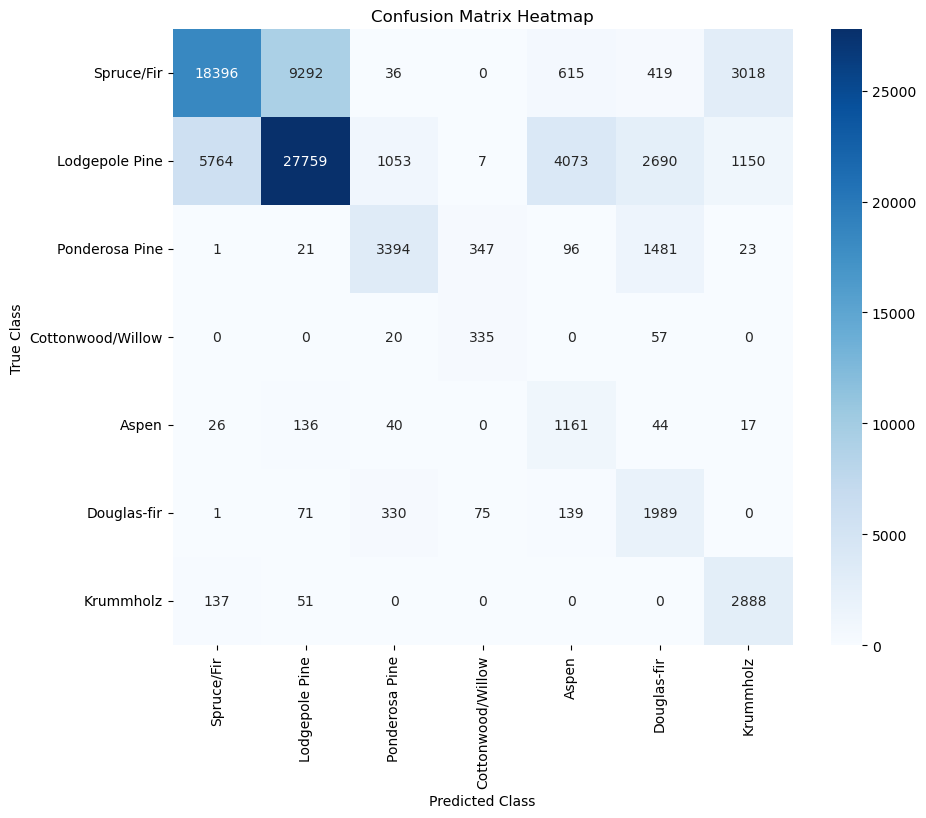

In [86]:
plot_cm(labels_pred, labels_test_enc)

The confusion matrix ilustrates the findings of the classification report. As an example, the model seems to be capturing most of the `Aspen` classes, with a lower amount of false negatives when compared to the model without class weights. However, over 4000 `Logepole Pine` areas have been missclassified as `Aspen`

In [59]:
# Decrease the weights for the classes 'Cottonwood/willow' 'Aspen' 'Douglas-fir' and 'krummholz' as they cause too many falso positive
class_weight_dict2 = {k: v/2 if k in [3,4,5,6] else v for k, v in class_weight_dict.items()}
class_weight_dict2

{0: 0.3918128429619582,
 1: 0.29298140717635446,
 2: 2.3214456951071942,
 3: 15.1069014189139,
 4: 4.371794044931742,
 5: 2.3896167992573356,
 6: 2.0234430193335258}

In [ ]:
weight_model = build_model(x_train_norm, 0.001)

# Instantiate a EarlyStopping object
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
# Select hyperparameter values
num_epochs = 50
batch_size = 1024

weight_history = weight_model.fit(
    x_train_norm,
    labels_train_enc,
    epochs=num_epochs, 
    batch_size=3,
    callbacks=[es],
    validation_data=(x_val_norm, labels_val_enc), 
    class_weight=class_weight_dict,
    verbose=1)

C:\Users\CristinaFC\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 203s 1ms/step - accuracy: 0.4966 - loss: 1.0084 - val_accuracy: 0.5326 - val_loss: 1.0028
Epoch 2/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 212s 2ms/step - accuracy: 0.5346 - loss: 0.7982 - val_accuracy: 0.5201 - val_loss: 1.1078
Epoch 3/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 215s 2ms/step - accuracy: 0.5640 - loss: 0.7528 - val_accuracy: 0.5402 - val_loss: 1.0278
Epoch 4/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 213s 2ms/step - accuracy: 0.5880 - loss: 0.6889 - val_accuracy: 0.6030 - val_loss: 0.8909
Epoch 5/50
135570/135570 ━━━━━━━━━━━━━━━━━━━━ 221s 2ms/step - accuracy: 0.5998 - loss: 0.6832 - val_accuracy: 0.6414 - val_loss: 0.8403
Epoch 6/50
 65788/135570 ━━━━━━━━━━━━━━━━━━━━ 1:39 1ms/step - accuracy: 0.6098 - loss: 0.6675